# **Técnicas Avanzadas de Aprendizaje**

##KNN - Accidentes cerebrovasculares##

###Andrea Azábal Lamoso###

14 de junio de 2021

---

# Preparación del entorno

Importamos los paquetes necesarios:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import re
import matplotlib.pyplot as plt

# Dataset

Nuestro objetivo es implementar un modelo predictivo que nos permita clasificar la probabilidad de sufrir un accidente cerebrovascular en función de las variables explicativas del *dataset*. El conjunto de datos que se utiliza para predecir si es probable que un paciente sufra un accidente cerebrovascular contiene las siguientes variables:

- Id: identificador único. 
- Gender: "Masculino", "Femenino" u "Otro". 
- Age: edad del paciente. 
- Hypertension: 0 si el paciente no tiene hipertensión, 1 si el paciente tiene hipertensión.
- Heart_disease: 0 si el paciente no tiene ninguna enfermedad cardíaca, 1 si el paciente tiene una enfermedad cardíaca. 
- Ever_married: si ha estado alguna vez casado: "No" o "Yes". 
- Work_type: "Children/Cuidado de hijos", "Govt_job/Funcionario del Gobierno", "Never_worked/Nunca ha trabajado", "Private/trabajador por cuenta ajena" o "Self-employeed/Trabajador por cuenta propia". 
- Residence_type: "Rural" o "Urbano". 
- Avg_glucose_level: nivel medio de glucosa en sangre. 
- Bmi: índice de masa corporal (IMC). 
- Smoking_status: "Fue fumador", "Nunca ha fumado", "Fuma actualmente" o "Desconocido". 
- Stroke: 1 si el paciente tuvo un accidente cerebrovascular o 0 si no lo tuvo. 




Importamos el fichero .csv:

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving act1_healthcare-dataset-stroke-data.csv to act1_healthcare-dataset-stroke-data.csv


Almacenamos los datos contenidos en el csv en un *dataframe*:

In [ ]:
path = "/content/act1_healthcare-dataset-stroke-data.csv"
df_ini = pd.read_csv(path, sep=",")
print (df_ini.shape)
df_ini.head(3)

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [ ]:
df_ini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Podemos comprobar que hemos importado 12 variables: 4 de tipo entero, 3 de tipo *float* y el resto son categóricas.

El indicador a predecir es *stroke*, el cual incluye información sobre si un paciente sufrió un accidente cerebrovascular o no. Si hacemos un desglose del indicador:

In [ ]:
df_ini["stroke"].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [ ]:
df_ini["stroke"].value_counts()/len(df_ini)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

Vemos que hay menos de un 5% de positivos para esta variable, por lo que el conjunto de datos está fuertemente desbalanceado. 

#KNN

El algoritmo que vamos a implementar para llevar a cabo la predicción es el de los k vecinos más cercanos​. Se trata de un método de clasificación supervisada, que estima la probabilidad de que un elemento pertenezca a una determinada clase a partir de la información proporcionada por el conjunto de datos. Es, por tanto, un método apropiado para el objetivo que hemos planteado.

El algoritmo calcula distancias en espacios n-dimensionales, siendo $n$ el número de variables predictoras ($X_1, X_2, ..., X_n$). Para que KNN funcione bien, precisa de calcular las distancias entre puntos que están en una zona común del espacio. Por esta razón, es necesario realizar un escalado previo de los datos de las variables predictoras.

Además, debe tenerse en cuenta que la variable dependiente toma el valor 0 en más del 95% de los casos, por lo que hay que tener cuidado a la hora de seleccionar un modelizado adecuado. Si nuestro modelo predice siempre 0, tendremos una *accuracy* del 95% aunque no estemos detectando ningún accidente cerebrovascular. 

Nuestro objetivo es intentar mejorar este resultado. Para ello, vamos a valernos de la función `KNNClassifier` y ajustar los parámetros más relevantes:

* **n_neighbors**: número de vecinos-cercanos a tener en cuenta para la predicción.

* **weights**: 
  * **Uniform**: para hacer el cálculo final de estimación/predicción no tiene en cuenta las distancias, sólo el número de puntos.
  * **Distance**: tiene en cuenta las distancias.

* **metric**: la fórmula que se va a utilizar para calcular las distancias. Las más usadas son Minkowski, Euclidean y Haversine.

* **n_jobs**: número de *cores* de nuestro sistema queremos usar para el cálculo.

Una vez hemos introducido el método por el que se va a computar la predicción, procedemos a preparar el *dataset*.

# Preprocesado de información

En primer lugar, observamos que en el *dataset* tenemos 201 valores para el IMC nulos:

In [ ]:
df_ini.isnull().sum(axis = 0)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Al tratarse de un bajo porcentaje, decidimos eliminarlos del *dataset*:

In [ ]:
df=df_ini.copy()
df = df[df['bmi'].notna()]
df.reset_index(drop=True, inplace=True)

Asimismo, vamos a convertir todas las variables categóricas en numéricas. Para ello, nos valemos de la función `labelEncoder()`, la cual asigna un valor numérica a cada categoría:

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
df["gender"]=le.fit_transform(df.gender)
df["ever_married"]=le.fit_transform(df.ever_married)
df["work_type"] = le.fit_transform(df.work_type)
df["Residence_type"]=le.fit_transform(df.Residence_type)
df["smoking_status"]=le.fit_transform(df.smoking_status)

Comprobamos que todas las variables categóricas son ahora de tipo entero:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909 entries, 0 to 4908
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   int64  
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   int64  
 4   heart_disease      4909 non-null   int64  
 5   ever_married       4909 non-null   int64  
 6   work_type          4909 non-null   int64  
 7   Residence_type     4909 non-null   int64  
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   int64  
 11  stroke             4909 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 460.3 KB


Además, como ya hemos argumentado, es necesario escalar los datos ya que, de no hacerlo, el algoritmo estará dando mayor peso a las magnitudes más altas. Por tanto:



In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit(df.iloc[:,0:-1]).transform(df.iloc[:,0:-1])

In [ ]:
dfs = pd.DataFrame(scaled, columns=df.columns[:-1])
dfs = pd.concat([dfs, df["stroke"]], axis=1)
dfs.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,-1.334653,1.198428,1.070138,-0.318067,4.381968,0.729484,-0.155697,0.985640,2.777698,0.981345,-0.351788,1
1,-0.283539,1.198428,1.646563,-0.318067,4.381968,0.729484,-0.155697,-1.014569,0.013842,0.459269,0.585232,1
2,1.101211,-0.833023,0.272012,-0.318067,-0.228208,0.729484,-0.155697,0.985640,1.484132,0.701207,1.522252,1
3,-1.686247,-0.833023,1.602222,3.143994,-0.228208,0.729484,0.759651,-1.014569,1.549193,-0.623083,0.585232,1
4,0.933870,1.198428,1.690903,-0.318067,-0.228208,0.729484,-0.155697,0.985640,1.821368,0.013595,-0.351788,1


Por último, al estar todas las observaciones stroke=1 en las primeras filas, vamos a desordenar el *dataset*:

In [ ]:
dfs = dfs.sample(frac=1.0, random_state=42)
dfs.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4153,0.797300,1.198428,1.646563,-0.318067,4.381968,0.729484,-0.155697,-1.014569,0.450584,0.510203,-1.288808,0
3543,-1.696298,-0.833023,-0.038371,-0.318067,-0.228208,-1.370831,-0.155697,0.985640,-0.478956,0.319200,0.585232,0
907,1.060912,1.198428,1.025798,3.143994,-0.228208,0.729484,-0.155697,-1.014569,-0.684495,0.408335,0.585232,0
2522,1.390928,1.198428,-0.614796,-0.318067,-0.228208,0.729484,-1.986391,0.985640,-0.065402,-0.253810,1.522252,0
3107,-1.080758,1.198428,0.183331,-0.318067,-0.228208,0.729484,-0.155697,-1.014569,-0.378551,-0.852287,1.522252,0


Así, el nuevo *dataframe* ya está listo para ser utilizado. Comprobamos que al escalar las variables, se ha llegado a un promedio de 0 y una varianza igual a 1:

In [ ]:
print ("Promedio:",round(dfs["smoking_status"].mean(),2))
print ("Varianza:",round(dfs["smoking_status"].std(),2))

Promedio: 0.0
Varianza: 1.0


#Modelizado

En primer lugar, definimos las variables dependiente ($y$) e independientes ($X_i$):

In [ ]:
X = dfs.iloc[:,0:-1]
Y = dfs.iloc[:,-1]

Vamos a calcular el valor de $k$ (en el rango $k \in [1,20]$) más adecuado con el método de *cross validation*. En particular, dividimos el *dataset* en 5 subconjuntos mediante `cv=5`. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score

In [ ]:
preds_list = []
score_list = []
k_list = []

for k in list(range(1, 20, 2)):
  knn_model = KNeighborsClassifier(n_neighbors=k, weights="uniform", metric="minkowski")
  preds = cross_val_predict(knn_model, X, Y, cv=5, method="predict", n_jobs=3)
  score = cross_val_score(knn_model, X, Y, cv=5, scoring="accuracy")
  k_list.append(k)
  preds_list.append(preds)
  score_list.append(score.mean())

Además, para el cálculo se ha seleccionado `weights="uniform"`, es decir, no se tienen en cuenta las distancias, y la métrica es de *Minkowski*. 

In [ ]:
df_scores = pd.DataFrame({"K":k_list, 
                   "score":score_list
                   })

Si representamos el resultado:

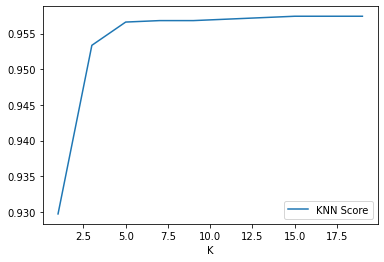

In [ ]:
df_scores.set_index("K")["score"].plot(label="KNN Score")
plt.legend()
plt.show();

El hecho de seleccionar un número inadecuado para los parámetros del ajuste puede llevarnos a un modelo fuertemente afectado por el *overfitting* o el *underfitting*, que no arroje buenas predicciones.

- El *underfitting* consiste en una modelización excesivamente simple, seleccionando demasiados vecinos próximos. En este caso particular, a partir de $k\geq8$ el modelo llega a un *plateau*, es decir, al tratarse de un *dataset* fuertemente desbalanceado en favor de la clase 0, el modelo está prediciendo siempre esa clase. Por tanto, vamos a quedarnos con $k<8$.

- El *overfitting* consiste en un ajuste excesivo al *dataset* de entrenamiento, de manera que el modelo se ajusta bien pero sus predicciones sobre otros conjuntos de datos son pobres. Esto ocurre cuando $k$ es muy pequeño, en particular, para $k<5$ se está dando este caso.

Además, antes de seleccionar un número óptimo de vecinos más cercanos, es necesario tener en cuenta que, al ser la variable respuesta a predecir dicotómica, hay que elegir un número impar para $k$.

En la gráfica se alcanza un máximo en el *score* a partir de $k=7$, por lo que seleccionamos este valor para el modelizado:

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=7, weights="uniform", metric="minkowski")
preds = cross_val_predict(knn_model, X, Y, cv=5, method="predict", n_jobs=3)
score = cross_val_score(knn_model, X, Y, cv=5, scoring="accuracy", n_jobs=3)
score

array([0.95621181, 0.95723014, 0.95723014, 0.95621181, 0.95718654])

El método de *cross validation* nos devuelve 5 valores para la *accuracy* de este modelo, todos en torno a 95,6%. A priori este valor podría parecer muy bueno, pero debemos recordar que nuestro conjunto de datos está altamente desbalanceado, por lo que el hecho de predecir siempre el mismo valor para la variable respuesta ya nos proporciona una precisión superior al 95%.

Si representamos la matriz de confusión del modelo:

In [ ]:
from sklearn.metrics import confusion_matrix
matriz=confusion_matrix(Y, preds)

##          predicciones
##            0      1
##       0   TN     FP
## real
##       1   FN     TP

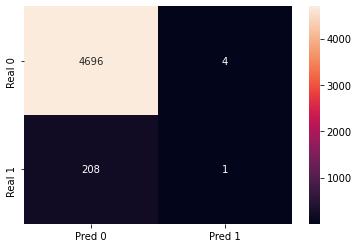

In [ ]:
sn.heatmap(pd.DataFrame(matriz), 
           annot=True,fmt='g',xticklabels=('Pred 0','Pred 1'),yticklabels=('Real 0','Real 1'))

Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa la clase real. En este caso en particular, estamos clasificando correctamente 4696 pacientes como negativos (verdaderos negativos), es decir, ninguno de ellos sufrió realmente un accidente cerebrovascular. Sin embargo, el otro valor de la diagonal nos indica el número de verdaderos positivos. Así, nuestro algoritmo no está siendo capaz de detectar correctamente los accidentes cerebrovasculares. De hecho, únicamente se han clasificado 5 observaciones como *stroke*=1 y solo una de ellas acertadamente (4 falsos positivos y 1 verdadero positivo). Por último, la celda restante nos dice el número de falsos negativos, es decir, de los 208 pacientes que realmente sufrieron el accidente cerebrovascular, no hemos sido capaces de detectar ninguno.

Con estos datos, la *accuracy* se calcula como

$$\text{Accuracy}=\frac{\text{TP}+\text{TN}}{\text{TP}+\text{FN}+\text{FP}+\text{TN}}=\frac{4696+1}{4698+208+1+4}=0.956 \ ,$$

llegando al mismo resultado calculado por el algoritmo.

Ante este resultado tan pobre, decidimos buscar alternativas para mejorar la predicción.

En concreto, decidimos modificar el tipo de ponderación a `weights="distance"`:

In [ ]:
preds_list = []
score_list = []
k_list = []

for k in list(range(1, 20, 2)):
  knn_model = KNeighborsClassifier(n_neighbors=k, weights="distance", metric="minkowski")
  preds = cross_val_predict(knn_model, X, Y, cv=5, method="predict", n_jobs=-1)
  score = cross_val_score(knn_model, X, Y, cv=5, scoring="accuracy")
  k_list.append(k)
  preds_list.append(preds)
  score_list.append(score.mean())

In [ ]:
df_scores = pd.DataFrame({"K":k_list, 
                   "score":score_list
                   })

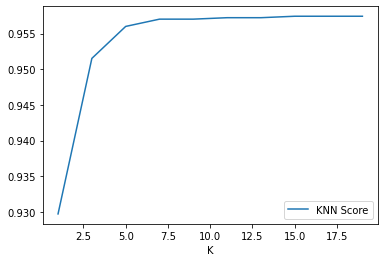

In [ ]:
df_scores.set_index("K")["score"].plot(label="KNN Score")
plt.legend()
plt.show();

De nuevo obtenemos un número óptimo para aproximadamente $k=7$, al igual que en el caso anterior. Vamos a quedarnos con este segundo modelizado para realizar una evaluación del mismo y ver si mejora en algo respecto a la primera especificación.

##Evaluación del modelo

A la hora de evaluar el ajuste del modelo, es útil conocer los siguientes indicadores:

- *Accuracy*: indica cuántos valores se han predicho correctamente en total.

$$ Accuracy =  \frac{TP+TN}{P+N}$$

- *Recall*: proporciona el porcentaje de verdaderos positivos respecto al total de positivos reales.

$$ Recall =  \frac{TP}{TP+FN}$$ 

- Precisión: indica el porcentaje de verdaderos positivos respecto al total de predicciones positivas, es decir, el porcentaje de aciertos para la predicción stroke=1.

$$ Precision =  \frac{TP}{TP+FP}$$ 

- F1 *score*: combinación de precisión y *recall*.

$$ F1 =  \frac{precision*recall}{precision+recall}$$ 

La *accuracy* devuelta por el método oscila en torno a 95,7%, de manera similar al primer modelo:

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=7, weights="distance", metric="minkowski")
preds = cross_val_predict(knn_model, X, Y, cv=5, method="predict", n_jobs=-1)
probs = cross_val_predict(knn_model, X, Y, cv=5, method="predict_proba", n_jobs=-1)
score = cross_val_score(knn_model, X, Y, cv=5, scoring="accuracy", n_jobs=-1)
score

array([0.95621181, 0.95723014, 0.95723014, 0.95621181, 0.95820591])

Sin embargo, como hemos comentado, un modelo que predice siempre 0 tiene una *accuracy* superior al 95%, es decir, la mejora no es muy significativa.

Gracias a la función `classification_report()` podemos obtener el resto de estadísticos:

In [ ]:
from sklearn.metrics import classification_report
print(f"Informe de Clasificación:\n"
      f"{classification_report(Y, preds)}")

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4700
           1       0.25      0.00      0.01       209

    accuracy                           0.96      4909
   macro avg       0.60      0.50      0.49      4909
weighted avg       0.93      0.96      0.94      4909



Así, el *recall* para la clase 1 es 0 (0.0048 en realidad) y su precisión es del 25%, es decir, el algoritmo no funciona correctamente para la predicción de esta clase. En otras palabras, no es capaz de detectar la inmensa mayoría de accidentes cerebrovasculares.



###Matriz de confusión

Las cantidades arriba resumidas se obtienen directamente de la matriz de confusión. Si la representamos:

In [ ]:
from sklearn.metrics import confusion_matrix
matriz=confusion_matrix(Y, preds)

##          predicciones
##            0      1
##       0   TN     FP
## real
##       1   FN     TP

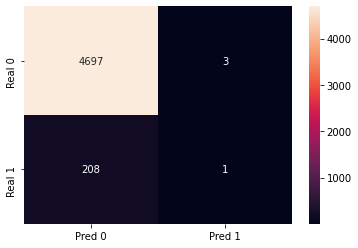

In [ ]:
sn.heatmap(pd.DataFrame(matriz), 
           annot=True,fmt='g',xticklabels=('Pred 0','Pred 1'),yticklabels=('Real 0','Real 1'))

Como ya habíamos argumentado, cada columna de la matriz representa el número de predicciones de cada clase, mientras que las filas representan la clase real. En este caso en particular, estamos clasificando correctamente 4697 pacientes como verdaderos negativos (ninguno de ellos sufrió realmente un accidente cerebrovascular) mientras que únicamente se han clasificado 4 observaciones como *stroke*=1, siendo solo una de ellas correcta (3 falsos positivos y 1 verdadero positivo). Por último, la celda restante nos dice el número de falsos negativos, es decir, de los 208 pacientes que realmente sufrieron el accidente cerebrovascular, no hemos sido capaces de detectar ninguno.

Así, por ejemplo:

$$ Accuracy =  \frac{TP+TN}{P+N} = \frac{1+4697}{1+4697+3+208}=0.957$$

Esta cantidad ha mejorado muy sensiblemente con respecto al resultado obtenido para el primer modelo ($0.976$). La razón es que ahora hay un falso positivo menos, que se ha transformado en un verdadero negativo. Aun así, nuestro modelo está lejos de ser idóneo.

###Curva ROC

Por último, podemos averiguar la capacidad de predicción del modelo mediante una curva ROC, en la cual se muestra el rendimiento del modelo en todos los umbrales de corte. Más en concreto, se representa la sensibilidad frente a la especificidad en diferentes umbrales de clasificación.

El umbral de clasificación es el valor que hace que clasifiquemos las distintas observaciones como positivas o negativas (por defecto se utiliza el umbral 0.5), por lo que, si se reduce el umbral, aumentarán tanto los falsos como los verdaderos positivos.

Mediante el algoritmo AUC, se está integrando el área bajo la curva ROC. Es decir, está proporcionando una medición agregada del rendimiento en todos los umbrales de clasificación posibles. Una forma de interpretar el AUC es como la probabilidad de que el modelo clasifique una observación 1 con una mayor probabilidad estimada que una observación 0. 

Para calcular la curva ROC, es necesario aplicar el modelo a un subconjunto de entrenamiento, por lo que procedemos a dividir el *dataset* en un 80% entrenamiento y un 20% prueba.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=42, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(3927, 11) (3927,)
(982, 11) (982,)


A continuación, pintamos la curva ROC:

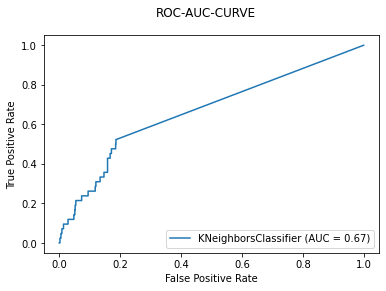

In [ ]:
from sklearn.metrics import plot_roc_curve
knn_model.fit(X_train, y_train)
plot_roc_curve(knn_model, X_test, y_test)
plt.suptitle("ROC-AUC-CURVE")
plt.show()

En esta curva estamos representando el ratio de verdaderos positivos (*recall*) frente al ratio de falsos positivos. Como hemos argumentado, el área bajo la curva es el valor del AUC.

A mayor AUC, mejores son las predicciones del modelo, es decir, distingue mejor la clase 0 de la clase 1. Asimismo, un valor de AUC=0.5 indica que hay un solapamiento total entre ambas clases, lo que significa que el modelo no es capaz de distinguir entre una clase y otra (es como realizar predicciones aleatorias).

Obtenemos un AUC=0.666 (para la clase 1):

In [ ]:
knn_model.predict_proba(X_test)[0:10]

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.87189471, 0.12810529],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.87063443, 0.12936557],
       [0.73641974, 0.26358026],
       [0.67975325, 0.32024675],
       [1.        , 0.        ]])

In [ ]:
from sklearn.metrics import roc_auc_score
print (roc_auc_score(y_test, knn_model.predict_proba(X_test)[:,0]))
print (roc_auc_score(y_test, knn_model.predict_proba(X_test)[:,1]))

0.33378926038500506
0.6662107396149949


Esto nos está indicando que nuestro modelo es capaz de separar las clases, aunque no muy bien, ya que $0.5<\text{AUC}<1$ lo cual indica que hay cierto solapamiento entre ambas.



##Umbral de clasificación

Según la curva ROC, el modelizado no es tan malo, por lo que deben existir umbrales de clasificación para los cuales consigamos mejorar la precisión y el *recall*.

Si decidimos probar con diferentes umbrales, en primer lugar vamos a almacenar las probabilidades de cada clase en un *dataframe*:

In [ ]:
df_dict = {"prob_class0": probs[:,0],
           "prob_class1": probs[:,1],
           "preds":preds}

In [ ]:
df_probs = pd.DataFrame(df_dict)
df_probs.head()

,prob_class0,prob_class1,preds
0,0.842077,0.157923,0
1,1.000000,0.000000,0
2,1.000000,0.000000,0
3,1.000000,0.000000,0
4,1.000000,0.000000,0


Vemos, por ejemplo, que la probabilidad más alta con la que se ha clasificado una predicción como 0 es de un 48%:

In [ ]:
df_probs[df_probs["preds"]==1]["prob_class0"].max()

0.48020740939240975

A continuación, nos valemos de la función `precision_recall_curve()` para obtener los valores de la precisión y el *recall* en función de unos determinados límites para las probabilidades de las predicciones del modelo:

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, limite = precision_recall_curve(Y,probs[:,1])

In [ ]:
precision

array([0.04257486, 0.09811321, 0.09820585, ..., 0.        , 0.        ,
       1.        ])

In [ ]:
recall

array([1.        , 0.49760766, 0.49760766, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
limite

array([0.        , 0.07187823, 0.07351254, ..., 0.52749176, 0.56354778,
       0.57764148])

Así, por ejemplo, cuando la probabilidad $\text{P}_1 \geq 0,07$, se tiene un *recall* de aproximadamente un 50% y una precisión en torno al 10%. Si representamos la curva completa:

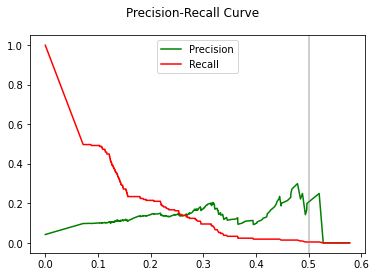

In [ ]:
plt.plot(limite, precision[:-1], c="green", label="Precision")
plt.plot(limite, recall[:-1], c="red", label="Recall")
plt.axvline(0.5, alpha=0.5, c="gray")
plt.suptitle("Precision-Recall Curve")
plt.legend()
plt.show()

La línea vertical representa el umbral actual del modelo, $0.5$. Las probabilidades superiores son clasificadas como 1 y las inferiores como 0. Como consecuencia, el modelo tiene un *recall* de 0 y una precisión del 25% como ya habíamos calculado.

Procedemos a definir los umbrales 5%, 10%, 20% y 30%:

In [ ]:
df_probs["preds_05"] = 0
df_probs["preds_10"] = 0
df_probs["preds_20"] = 0
df_probs["preds_30"] = 0

df_probs.loc[df_probs["prob_class1"]>0.05, "preds_05"] = 1
df_probs.loc[df_probs["prob_class1"]>0.1, "preds_10"] = 1
df_probs.loc[df_probs["prob_class1"]>0.2, "preds_20"] = 1
df_probs.loc[df_probs["prob_class1"]>0.3, "preds_30"] = 1

In [ ]:
#df_probs

- Umbral al 5%:

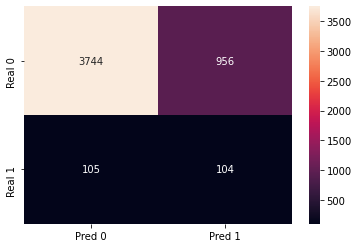

In [ ]:
matriz05=confusion_matrix(Y, df_probs["preds_05"].values)
sn.heatmap(matriz05, 
           annot=True,fmt='g',xticklabels=('Pred 0','Pred 1'),yticklabels=('Real 0','Real 1'))

- Umbral al 10%:

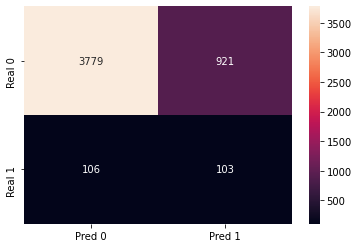

In [ ]:
matriz10=confusion_matrix(Y, df_probs["preds_10"].values)
sn.heatmap(matriz10,
           annot=True,fmt='g',xticklabels=('Pred 0','Pred 1'),yticklabels=('Real 0','Real 1'))

- Umbral al 20%:

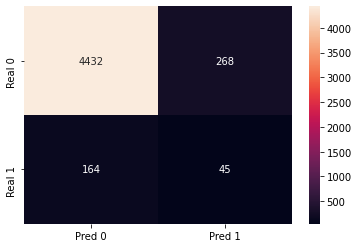

In [ ]:
matriz20=confusion_matrix(Y, df_probs["preds_20"].values)
sn.heatmap(matriz20, 
           annot=True,fmt='g',xticklabels=('Pred 0','Pred 1'),yticklabels=('Real 0','Real 1'))

- Umbral al 30%:

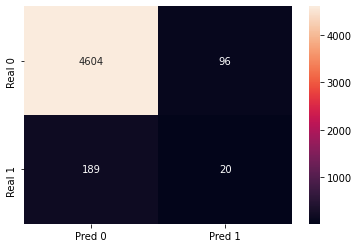

In [ ]:
matriz30=confusion_matrix(Y, df_probs["preds_30"].values)
sn.heatmap(matriz30, 
           annot=True,fmt='g',xticklabels=('Pred 0','Pred 1'),yticklabels=('Real 0','Real 1'))
##          predicciones
##            0      1
##       0   TN     FP
## real
##       1   FN     TP

Vemos como, a medida que se aumenta el umbral de clasificación (la probabilidad límite para separar las predicciones entre clases), va aumentando el número de predicciones clasificadas como 0 y disminuyendo las predicciones clasificadas a 1, como es lógico. Es decir, hay un aumento de verdaderos y falsos negativos, mientras que disminuyen los verdaderos y falsos positivos.

Resumimos en la siguiente tabla los resultados para cada umbral:

|  Umbral de clasificación | *Accuracy*  |  *Recall*  |  *Precision*  |
|----------------------    |------------ |------------|------------   |
|             $5\%$        |    0.784    |   0.500    |     0.098     |
|             $10\%$       |    0.791    |   0.493    |     0.100     |
|             $20\%$       |    0.912    |   0.215    |     0.144     |
|             $30\%$       |    0.942    |   0.096    |     0.172     |


Recordemos que nuestro objetivo era disminuir el número de falsos negativos, es decir, aumentar el *recall*, a costa de aumentar el número de falsos positivos (disminuyendo la precisión). Como vemos en la tabla, esto se consigue disminuyendo el umbral de clasificación.

El umbral óptimo dependerá de la capacidad del sistema sanitario para manejar los falsos positivos. Si tenemos un sistema que es capaz de realizar pruebas diagnósticas a un amplio número de pacientes, entonces un umbral de clasificación en torno al 10% nos garantiza detectar la mayoría de accidentes cerebrovasculares. En cambio, si no se tiene una gran capacidad de realización de pruebas diagnósticas, será necesario aumentar este umbral hasta un intervalo entre el 20% y el 30%.

#Conclusiones

De los modelizados propuestos inicialmente, hemos seleccionado aquel que ponderaba las observaciones vecinas en función de sus distancias (`weights="distance"`). Además, hemos llegado a la conclusión de que considerar un número de vecinos próximos $k<5$ causa *overfitting*, mientras que $k>8$ arroja un modelo demasiado simplista (*underfitting*), por lo que se ha seleccionado $k=7$.

Asimismo, los parámetros calculados a partir de la matriz de confusión del modelo (*accuracy*, *recall*, etc.) indicaban que nuestro umbral de clasificación no es el óptimo, ya que el modelo no es capaz de separar bien entre clases. Al haber calculado el área bajo la curva ROC, obteniendo un valor superior a 0.5, sabemos que el modelo es capaz de separar hasta cierto punto entre ambas clases, por lo que se ha propuesto disminuir el umbral de clasificación con el fin de aumentar el *recall*.

Finalmente, se concluye que umbrales entre el 10% y el 30% son los más apropiados si lo que buscamos es detectar un gran número de verdaderos positivos (disminuir falsos negativos). El valor exacto dependerá del número de falsos positivos que tengamos capacidad de gestionar.